## Strandard Import

In [1]:
# Import necessary modules and functions

import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8

from scipy.stats import norm
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

## Explore Data

### Import Data

In [2]:
df_ks_to_display = pd.read_csv('KS_train_data.csv', delimiter= ',')

### Describe Data

#### Numerical Features

In [3]:
df_ks_to_display.describe()

,backers_count,converted_pledged_amount,created_at,deadline,fx_rate,goal,launched_at,pledged,usd_pledged
count,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05
mean,151.089430,1.241108e+04,1.400524e+09,1.406896e+09,1.017654,4.447512e+04,1.403972e+09,1.312485e+04,1.241284e+04
std,1163.024964,1.005545e+05,6.334581e+07,6.340574e+07,0.169773,1.256033e+06,6.360489e+07,1.080345e+05,1.005368e+05
min,0.000000,0.000000e+00,1.240366e+09,1.243556e+09,0.009337,1.000000e-02,1.240674e+09,0.000000e+00,0.000000e+00
25%,4.000000,1.250000e+02,1.349203e+09,1.357171e+09,1.000000,1.500000e+03,1.354313e+09,1.250000e+02,1.250000e+02
50%,28.000000,1.650000e+03,1.408426e+09,1.415244e+09,1.000000,5.000000e+03,1.412373e+09,1.635500e+03,1.651000e+03
75%,86.000000,6.271250e+03,1.447206e+09,1.454243e+09,1.000000,1.200000e+04,1.451252e+09,6.310000e+03,6.275042e+03
max,105857.000000,1.026684e+07,1.517539e+09,1.518702e+09,1.401112,1.000000e+08,1.518037e+09,1.026685e+07,1.026685e+07


We have noticed that the goals of these projects are not using the same currency unit.

#### Goal

In [4]:
df_ks_to_display['usd_goal'] = df_ks_to_display['goal'] * df_ks_to_display['fx_rate']
df_ks_to_display['usd_goal'].describe()

count    1.000000e+05
mean     4.052436e+04
std      1.191352e+06
min      1.000000e-02
25%      1.500000e+03
50%      5.000000e+03
75%      1.200000e+04
max      1.401112e+08
Name: usd_goal, dtype: float64

#### Percentage of Success

In [5]:
df_ks_to_display['pt_success'] = df_ks_to_display['usd_pledged'] / df_ks_to_display['usd_goal']
df_ks_to_display['pt_success'].describe()


count    100000.000000
mean          3.282139
std         165.490788
min           0.000000
25%           0.028995
50%           1.017750
75%           1.232006
max       41535.010000
Name: pt_success, dtype: float64

In [6]:
#Data is too large to be plotted, the statement below does not work
#sns.displot(df_ks_to_display['pt_success'])

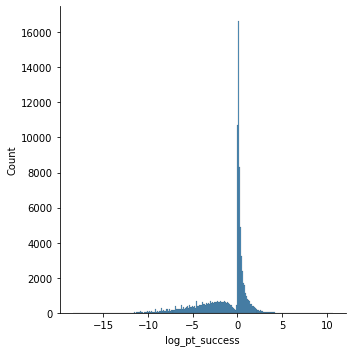

In [7]:
#Logarize the percentages of success to plot them
df_ks_to_display['log_pt_success'] = np.log(df_ks_to_display['pt_success'])
sns.displot(df_ks_to_display['log_pt_success'])

#### Promotion Duration

In [8]:
duration_dis = pd.to_datetime(df_ks_to_display['deadline'], unit='s') - pd.to_datetime(df_ks_to_display['launched_at'], unit='s')

# translate the yyyy-mm-dd format to int
df_ks_to_display['promotion_duration'] = duration_dis / np.timedelta64(1, 'D')

df_ks_to_display['promotion_duration'].describe()

count    100000.000000
mean         33.840738
std          12.953758
min           1.000000
25%          30.000000
50%          30.000000
75%          36.000000
max          91.958333
Name: promotion_duration, dtype: float64

### Missing Data and Outlier Detection

#### **Outlier Detection**

**pt_success outliers**

In [9]:
outliers = df_ks_to_display.loc[df_ks_to_display['pt_success'] > 5]
print(outliers)

      project_id  backers_count  \
7      KS_000007            479   
70     KS_000070            141   
97     KS_000097            678   
100    KS_000100            139   
145    KS_000145           2040   
...          ...            ...   
98956  KS_098956             36   
98959  KS_098959            331   
99095  KS_099095             21   
99472  KS_099472             44   
99990  KS_099990             59   

                                                   blurb    category  \
7      Portrait artist seeks funds to kickstart an ex...         art   
70     "Cities of You" envisions people as imaginary ...         art   
97     Hand-made screenprints & t-shirts about the be...         art   
100    Getting caught up in trying to please others w...         art   
145    It might be the worlds first ever podcast rele...         art   
...                                                  ...         ...   
98956  Machine Learning can now be done in the web br...  technology   
989

**Typical Extreme case**

```
index = 54553
goal = 1
pledged = 41535
category = game
```

**Kill outliers**

In [ ]:
df_ks_to_display.drop(outliers, inplace=True)

**Check new data**

In [ ]:
df_ks_to_display['pt_success'].describe()

#### Clear invalid data

In [10]:
hm_features = ['backers_count', 'converted_pledged_amount','promotion_duration','usd_goal', 'staff_pick','pt_success',]
nulls = df_ks_to_display[hm_features].isnull().sum()
print(nulls)

backers_count               0
converted_pledged_amount    0
promotion_duration          0
usd_goal                    0
staff_pick                  0
pt_success                  0
dtype: int64


### Explore other features

#### **Category**

**A boxplot for the percentages of success versus the categories**

<AxesSubplot:xlabel='pt_success', ylabel='category'>

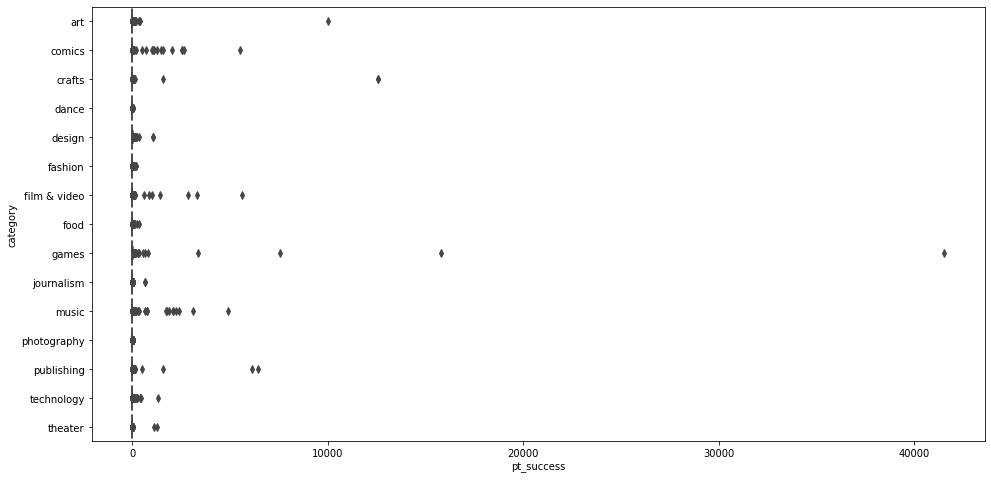

In [11]:
sns.boxplot(df_ks_to_display['pt_success'], df_ks_to_display['category'])

**Logarize pt_success for better visual effect**

In [ ]:
sns.boxplot(df_ks_to_display['log_pt_success'], df_ks_to_display['category'])

#### Sub-catetory

In [12]:
df_ks_to_display['subcategory'].describe()

count     100000
unique       158
top          web
freq        2302
Name: subcategory, dtype: object

**The ten most frequently occurring subcategories**

In [13]:
n = 10
sc_top_10 = df_ks_to_display['subcategory'].value_counts()[:n].index
print(sc_top_10)

Index(['web', 'product design', 'shorts', 'documentary', 'hardware',
       'indie rock', 'nonfiction', 'fiction', 'rock', 'mixed media'],
      dtype='object')


**A boxplot for the logarithms of percentages of success versus the top ten subcategories**

<AxesSubplot:xlabel='log_pt_success', ylabel='subcategory'>

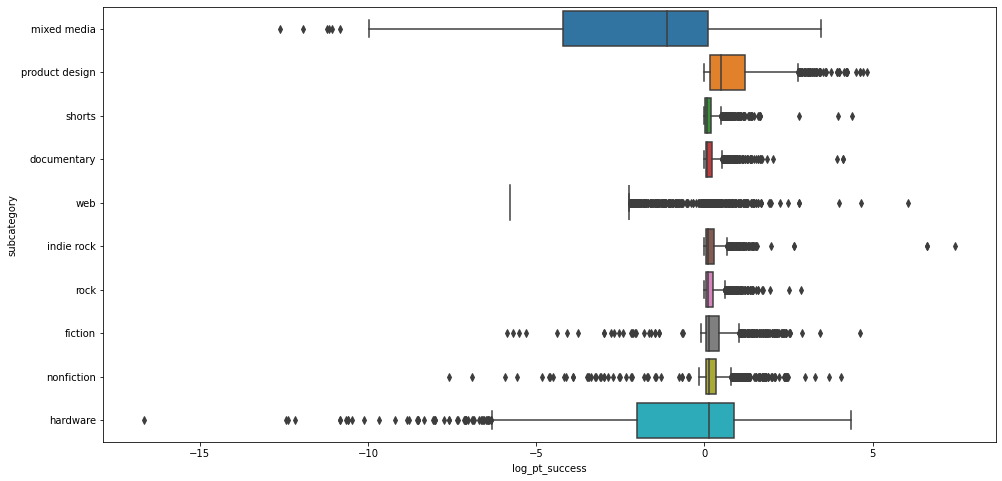

In [14]:
top_scs = df_ks_to_display.loc[df_ks_to_display['subcategory'].isin(sc_top_10)]
sns.boxplot(top_scs['log_pt_success'], top_scs['subcategory'])

#### **Country**

In [15]:
df_ks_to_display['country'].describe()

count     99997
unique      174
top          US
freq      76716
Name: country, dtype: object

**Top 10 countries**

In [16]:
n = 10
top_10 = df_ks_to_display['country'].value_counts()[:n].index
print(top_10)

Index(['US', 'GB', 'CA', 'AU', 'DE', 'FR', '?', 'NL', 'IT', 'ES'], dtype='object')


**Select top 10 countries records**

In [17]:
tops = df_ks_to_display.loc[df_ks_to_display['country'].isin(top_10)]
print(tops)

      project_id  backers_count  \
0      KS_000000             80   
1      KS_000001             82   
2      KS_000002             21   
3      KS_000003             37   
4      KS_000004            153   
...          ...            ...   
99995  KS_099995            104   
99996  KS_099996            307   
99997  KS_099997            143   
99998  KS_099998            329   
99999  KS_099999            145   

                                                   blurb category  \
0      I will be an artist-in-residence at Elsewhere ...      art   
1      1000 Artists is a public art-making installati...      art   
2      The Sequel to ‘My Favorite Machine”, "MyPhoneH...      art   
3      A film exploring the role and value of art edu...      art   
4      We need to build a kitchen for Habitable Space...      art   
...                                                  ...      ...   
99995  Make the workshop/ small stage space at Jimmy'...  theater   
99996  Help create a perman

**A boxplot for the percentages of success versus the top ten countries**

<AxesSubplot:xlabel='pt_success', ylabel='country'>

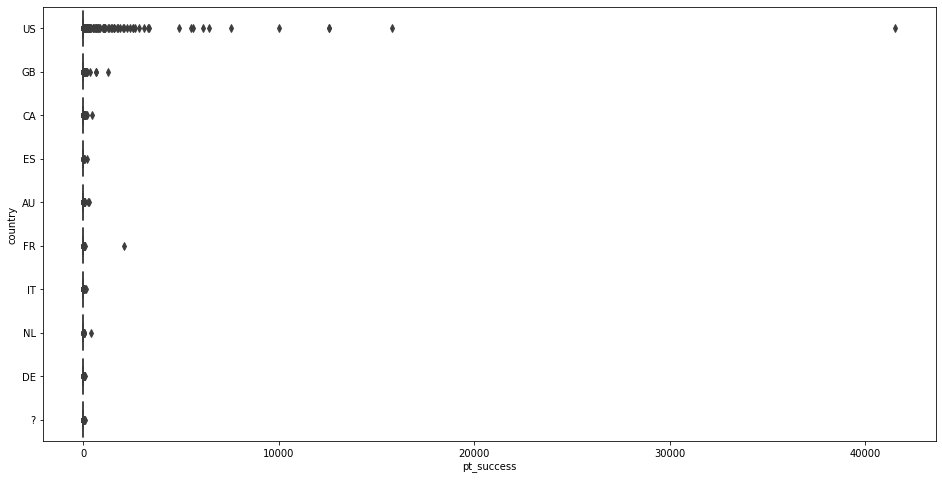

In [18]:
sns.boxplot(tops['pt_success'], tops['country'])

**A boxplot for the logarithms of percentages of success versus the top ten countries**

<AxesSubplot:xlabel='log_pt_success', ylabel='country'>

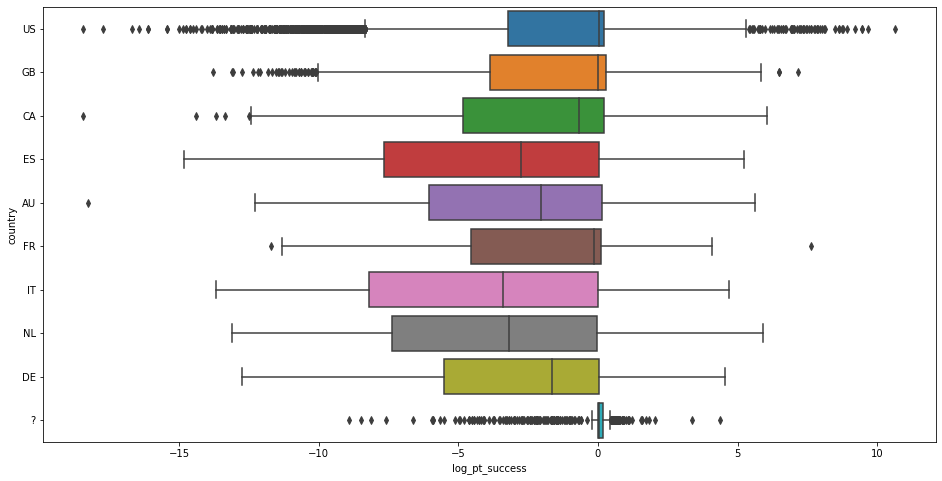

In [19]:
sns.boxplot(tops['log_pt_success'], tops['country'])

#### Count Blurb length

In [20]:
df_ks_to_display['blurb_length'] = df_ks_to_display['blurb'].str.len()

In [21]:
df_ks_to_display['blurb_length'].describe()

count    99998.000000
mean       115.143353
std         24.758182
min          1.000000
25%        106.000000
50%        125.000000
75%        133.000000
max        152.000000
Name: blurb_length, dtype: float64

In [22]:
# Cannot be plotted
# sns.boxplot(df_ks_to_display['log_pt_success'], df_ks_to_display['blurb_length'])

#### **HeatMap**

<AxesSubplot:>

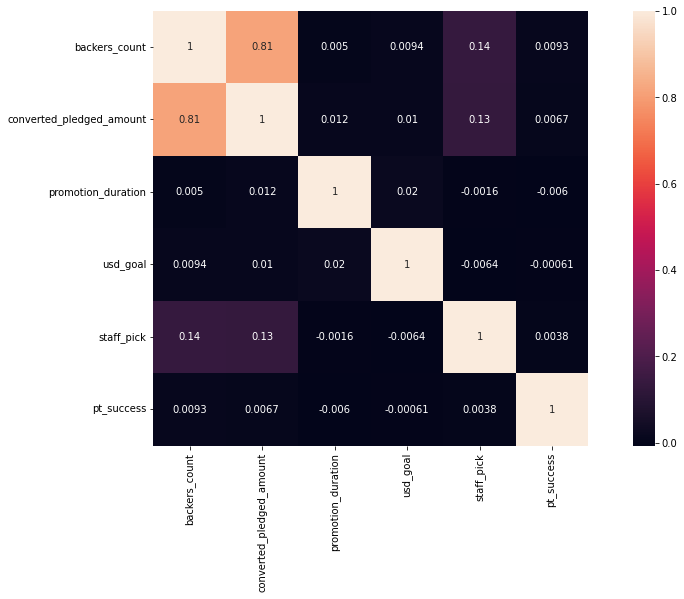

In [23]:
corrmat_all = df_ks_to_display[hm_features].corr()
sns.heatmap(corrmat_all,square=True, annot=True)

**Logarize the converted goal to plot the heatmap**

In [24]:
df_ks_to_display['log_usd_goal'] = np.log(df_ks_to_display['usd_goal'])

In [25]:
hm_features = ['blurb_length','promotion_duration','log_usd_goal', 'staff_pick','log_pt_success']

<AxesSubplot:>

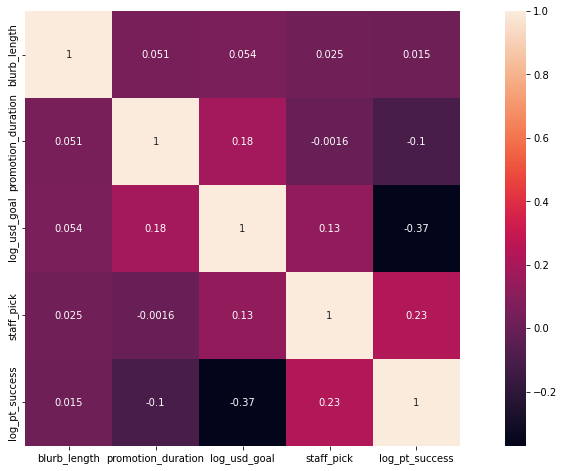

In [26]:
corrmat_all = df_ks_to_display[hm_features].corr()
sns.heatmap(corrmat_all,square=True, annot=True)